## Generador de Prediccion Estandar

In [35]:
#Se limpia la memoria
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,750937,40.2,1786861,95.5,1786861,95.5
Vcells,22234829,169.7,395749939,3019.4,486028517,3708.2


In [36]:
semilla <- 100019
set.seed(semilla)

In [37]:
#cargo las librerias que necesito
require("data.table")
require("rpart")
require("rpart.plot")
#Contiene funciones para evaluar performance de la clasificación
library("ROCR")

In [38]:
setwd("C:/_MCD/Labo1/code")  #Establezco el Working Directory

In [39]:
dataset  <- fread("./datasets/competencia1_2022_FE_DC2.csv")

In [40]:
dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar
dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

In [41]:
modelo  <- rpart(formula=    "clase_ternaria ~ .", #quiero predecir clase_ternaria a partir de el resto de las variables
                 data =      dtrain,  #los datos donde voy a entrenar
                 xval=       0,
                 cp=        -0.2534, #esto significa no limitar la complejidad de los splits
                 minsplit= 1104,   #minima cantidad de registros para que se haga el split
                 minbucket=  528,   #tamaño minimo de una hoja
                 maxdepth=  13 )  #PRUEBO  una profundidad de 10


Ahora grafico el arbol, va a ser muy frondoso porque la profundidad es de 10

In [42]:
#prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0)

Ahora aplico al modelo  a los datos muevos  y genero la salida para kaggle

aplico el modelo a los datos nuevos

In [53]:
prediccion  <- predict( modelo, dapply , type = "prob") #aplico el modelo

In [54]:
dfinal  <- dapply
dfinal[ , prob_baja2 := prediccion[ , "BAJA+2"] ]

In [55]:
dfinal[ , azar := runif( nrow(dapply) ) ]

# ordeno en forma descentente, y cuando coincide la probabilidad, al azar
setorder( dfinal, -prob_baja2,azar )


In [56]:
for( corte  in  c( 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000 ) )
{
  #le envio a los  corte  mejores,  de mayor probabilidad de prob_SI
  dfinal[ , Predicted := 0L ]
  dfinal[ 1:corte , Predicted := 1L ]

  fwrite( dfinal[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
           file= paste0( "./exp/competencia1/prediccion_alt_",  corte, ".csv"),
           sep=  "," )
}

### Ganancia

In [57]:
prediccion  <- predict( modelo, dtrain , type = "prob") #aplico el modelo

dtrain[ , prob_SI := prediccion[ , "BAJA+2"] ]
dtrain[ , azar := runif( nrow(dtrain) ) ]
setorder( dtrain, -prob_SI, azar )

for( corte  in  c( 7500, 8000, 8500, 9000, 9500, 9527,10000, 10500, 11000 ) )
{
  #le envio a los  corte  mejores,  de mayor probabilidad de prob_SI
  dtrain[ , Predicted := 0L ]
  dtrain[ 1:corte , Predicted := 1L ]

    dtrain[, clase := 0]
    dtrain[ clase_ternaria=='BAJA+2' ,   clase:= 1]
    
    #Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Calculo la ganancia
dtrain[  , ganancia:= kFPGain ] #-1250
dtrain[ clase_ternaria=='BAJA+2' ,   ganancia:= kTPGain] #48750
sum( dtrain$ganancia )

gan <- sum( dtrain[ dtrain$Predicted==1, ganancia] )

#TP
truepositive <- sum(dtrain$Predicted*dtrain[,clase])

#Incentivados Totales
incentivados <- sum(dtrain$Predicted)
print(paste("      Corte:",corte))
print(paste("      La Ganancia es:", gan))
print(paste("      TP:", truepositive))
print(paste("      Incentivados:",incentivados))
print("     ")
}

[1] "      Corte: 7500"
[1] "      La Ganancia es: 25240000"
[1] "      TP: 503"
[1] "      Incentivados: 7500"
[1] "     "
[1] "      Corte: 8000"
[1] "      La Ganancia es: 25520000"
[1] "      TP: 519"
[1] "      Incentivados: 8000"
[1] "     "
[1] "      Corte: 8500"
[1] "      La Ganancia es: 25320000"
[1] "      TP: 529"
[1] "      Incentivados: 8500"
[1] "     "
[1] "      Corte: 9000"
[1] "      La Ganancia es: 25680000"
[1] "      TP: 546"
[1] "      Incentivados: 9000"
[1] "     "
[1] "      Corte: 9500"
[1] "      La Ganancia es: 25480000"
[1] "      TP: 556"
[1] "      Incentivados: 9500"
[1] "     "
[1] "      Corte: 9527"
[1] "      La Ganancia es: 25506000"
[1] "      TP: 557"
[1] "      Incentivados: 9527"
[1] "     "
[1] "      Corte: 10000"
[1] "      La Ganancia es: 25520000"
[1] "      TP: 569"
[1] "      Incentivados: 10000"
[1] "     "
[1] "      Corte: 10500"
[1] "      La Ganancia es: 25480000"
[1] "      TP: 581"
[1] "      Incentivados: 10500"
[1] "     "
[1] 

grabo el dataset

In [48]:
nombre_archivo_salida <- "./exp/competencia1/inicial.csv"

In [49]:
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= nombre_archivo_salida, 
        sep= "," )

In [50]:
options(scipen=999)

In [51]:
modelo

n= 161342 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

    1) root 161342 1514 CONTINUA (0.00411548140 0.00526831203 0.99061620657)  
      2) mgasto_mensual_estim< 3491.545 10635  874 CONTINUA (0.03620122238 0.04598025388 0.91781852374)  
        4) mprestamos< 15509.58 7881  816 CONTINUA (0.04593325720 0.05760690268 0.89645984012)  
          8) cdescubierto_preacordado< 0.5 826  208 CONTINUA (0.10169491525 0.15012106538 0.74818401937) *
          9) cdescubierto_preacordado>=0.5 7055  608 CONTINUA (0.03940467753 0.04677533664 0.91381998583)  
           18) mcuentas_saldo_mas_invers_mas_caja_seg< -750.135 2468  349 CONTINUA (0.06482982172 0.07658022690 0.85858995138)  
             36) prop_margen_rent_mes< 0.2902825 1522  278 CONTINUA (0.08804204993 0.09461235217 0.81734559790)  
               72) mrentabilidad_annual< 11756.24 864  181 CONTINUA (0.09953703704 0.10995370370 0.79050925926) *
               73) mrentabilidad_annual>=11756.24 658   97 CONTINU

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


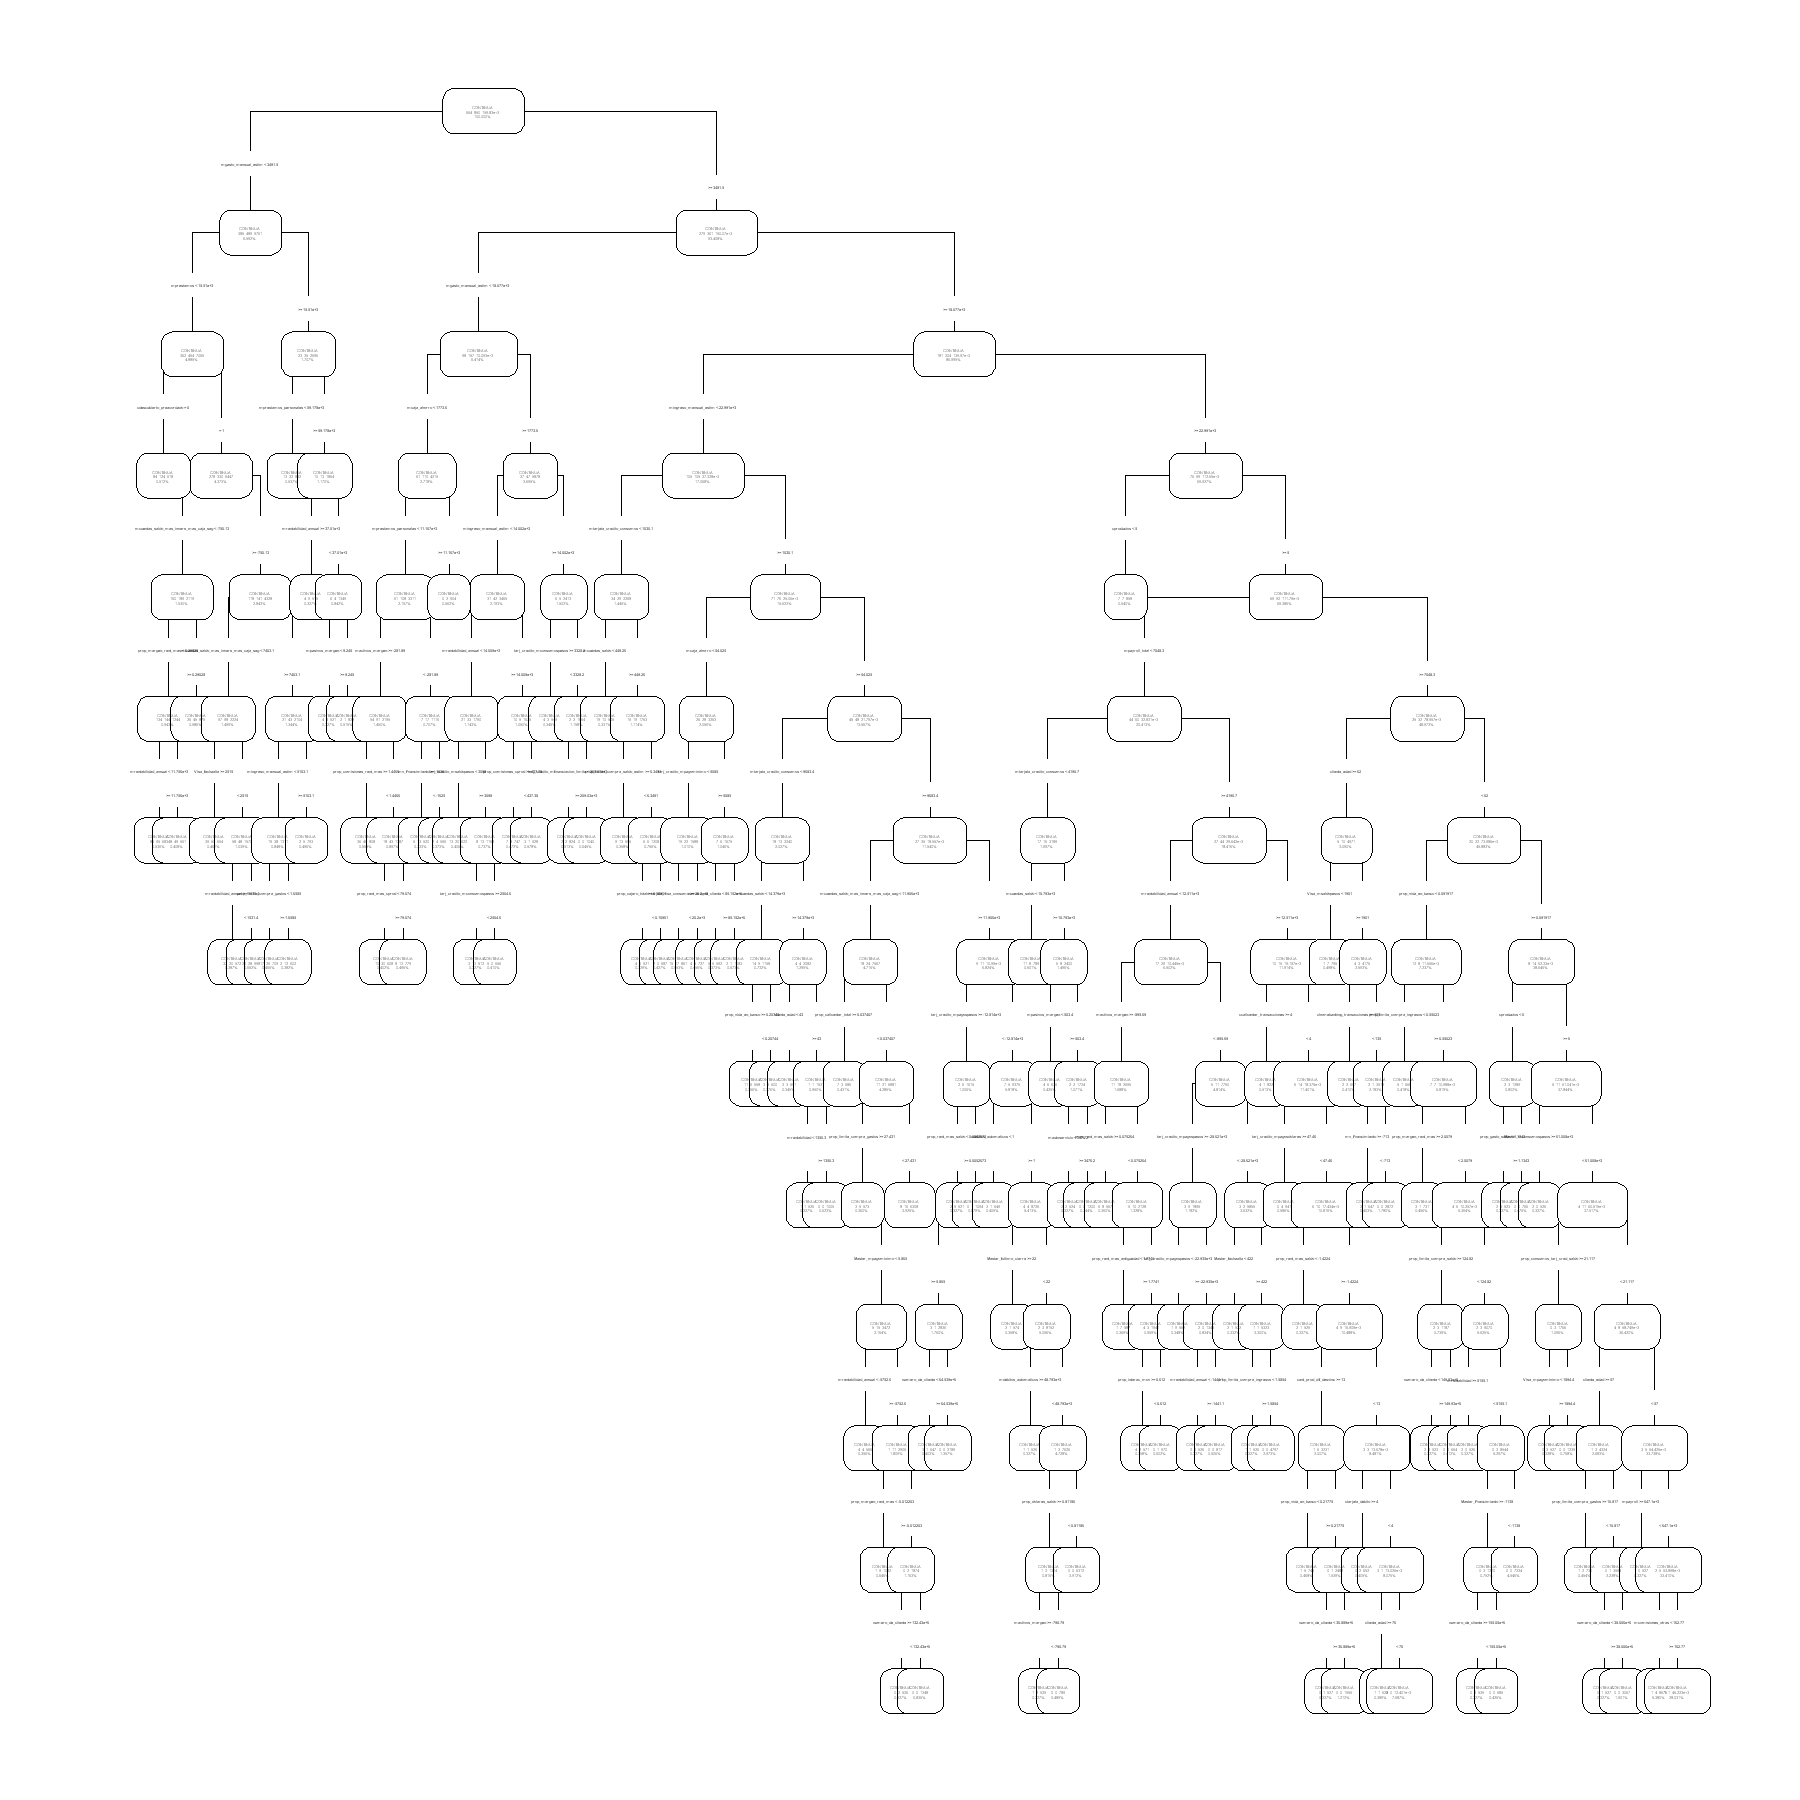

In [52]:
#Arbol generado
options(repr.plot.width=15, repr.plot.height=15)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)